In [ ]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
data = pd.read_csv("sensor.csv", encoding = 'utf-8', delimiter=',')
data.head(5)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f745d8c1908>,
      dtype=object)

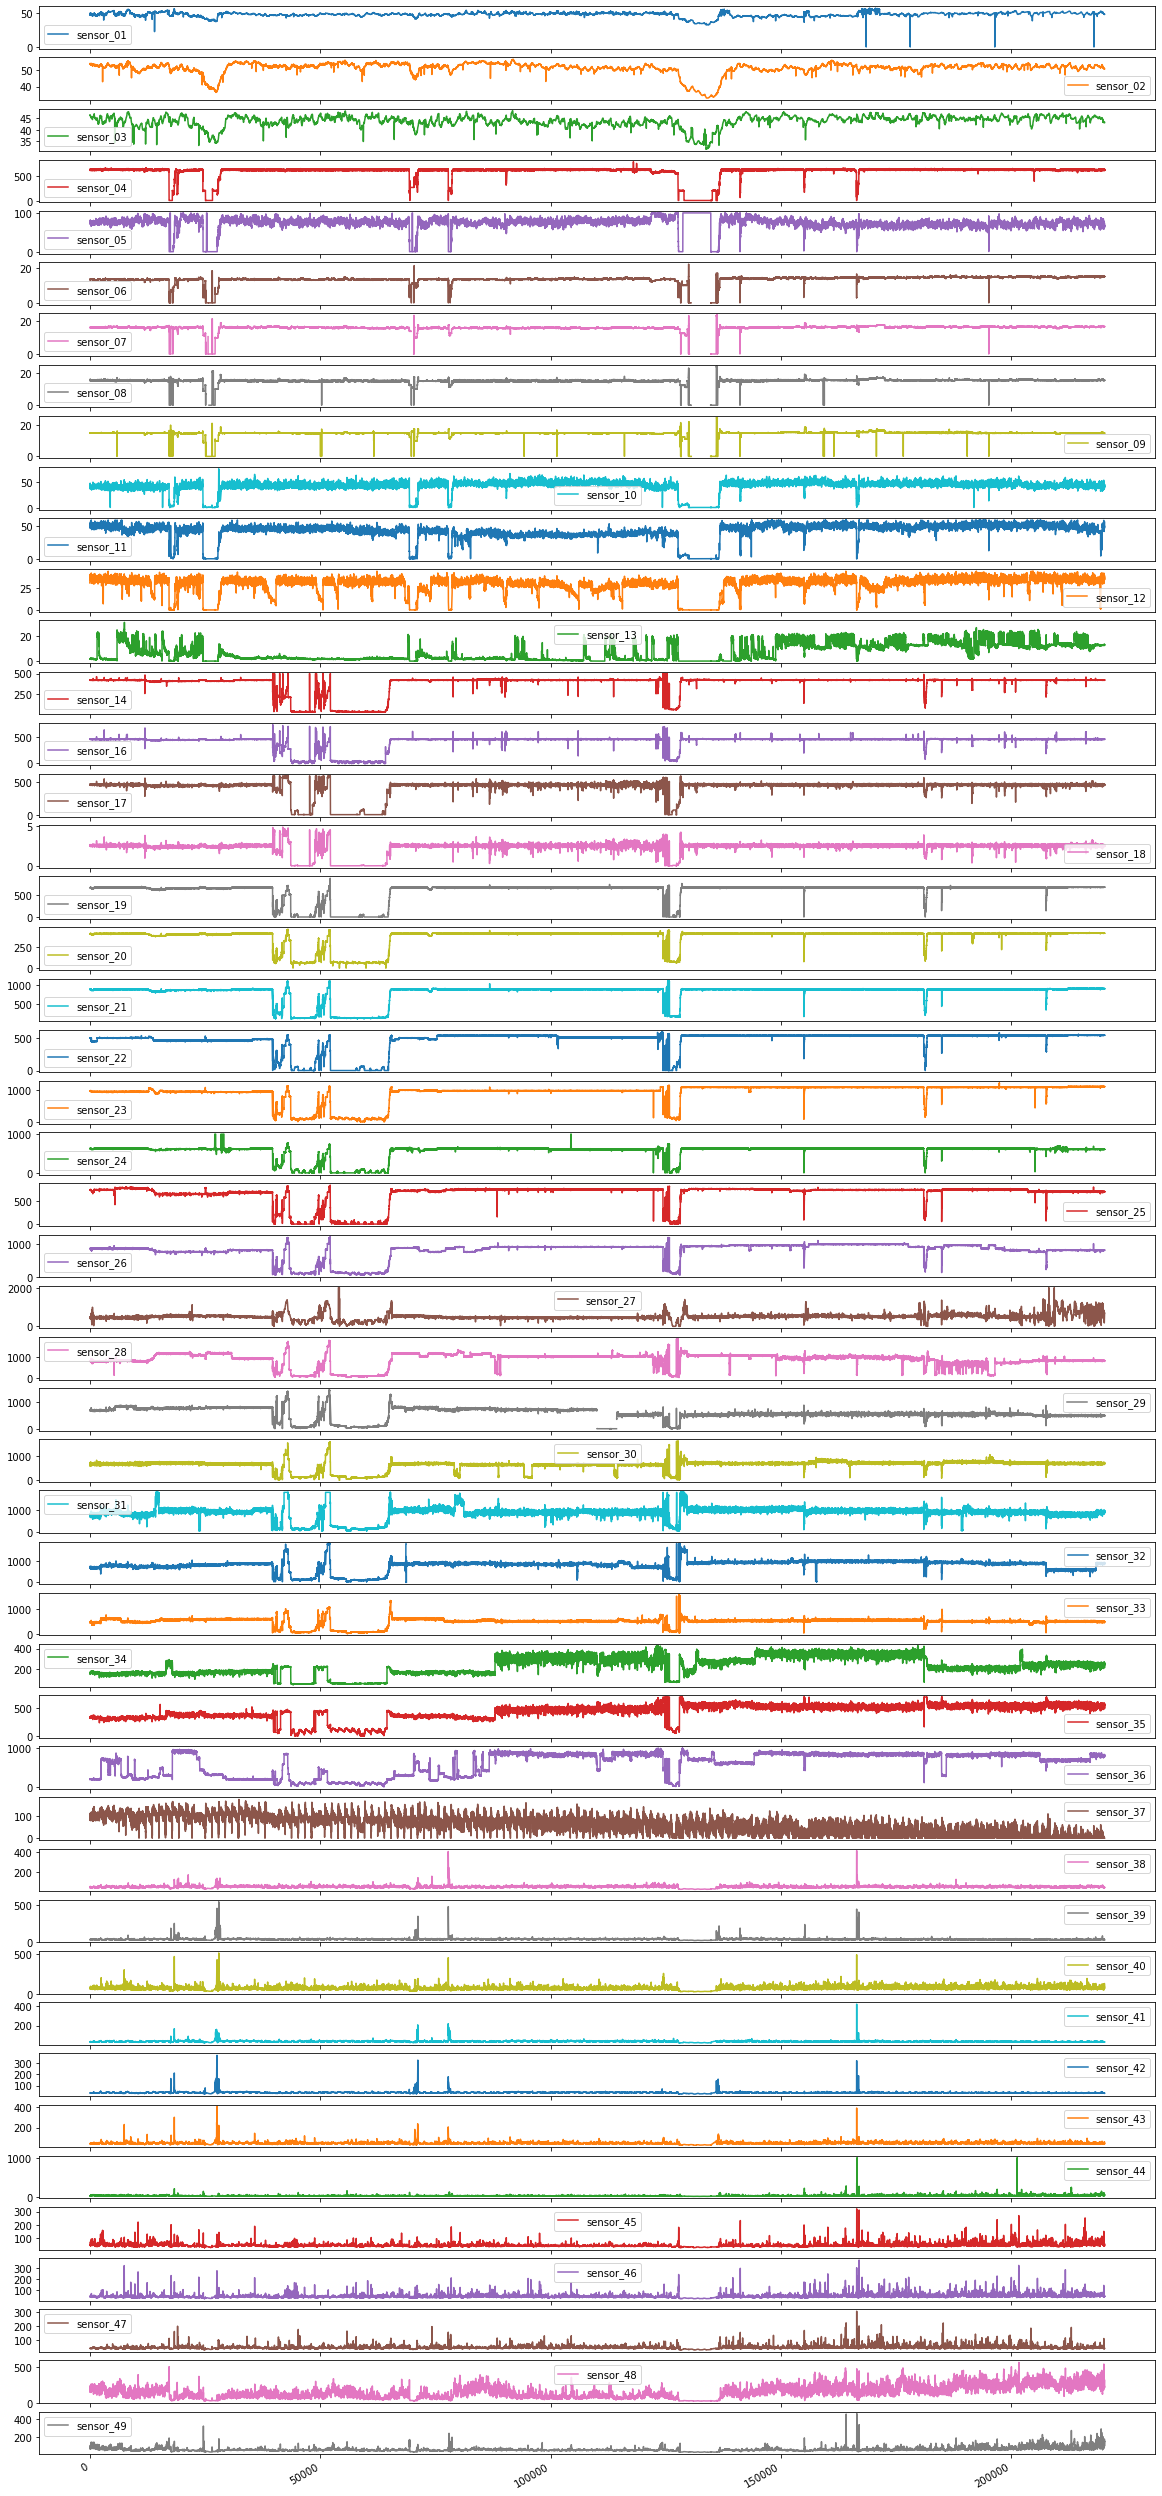

In [ ]:
data.drop(['Unnamed: 0', 'timestamp','sensor_00','sensor_15','sensor_50','sensor_51'],axis=1, inplace=True)
import matplotlib.pyplot as plt
data.plot(subplots =True, sharex = True, figsize = (20,50))

In [ ]:
data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [ ]:
conditions = [(data['machine_status'] =='NORMAL'), (data['machine_status'] =='BROKEN'), (data['machine_status'] =='RECOVERING')]
choices = [1, 0, 0.5]
data['Operation'] = np.select(conditions, choices, default=0)
#database has 7 BROKEN states, which are then RECOVERED and returned to a NORMAL operating state. 

patterns by sensor num
+ (1,2,3), 
+ (4,5,6,7,8,9), 5??
+ (10,11,12), 
+ (14,16,17,18), 
+ (19,20,21,22,23,24), 
+ (25,26,28,29,30,31,32,33), 
+ (34,35), 
+ (38,39,40,41,42,43,45,46,47).  

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f745c427d30>,
      dtype=object)

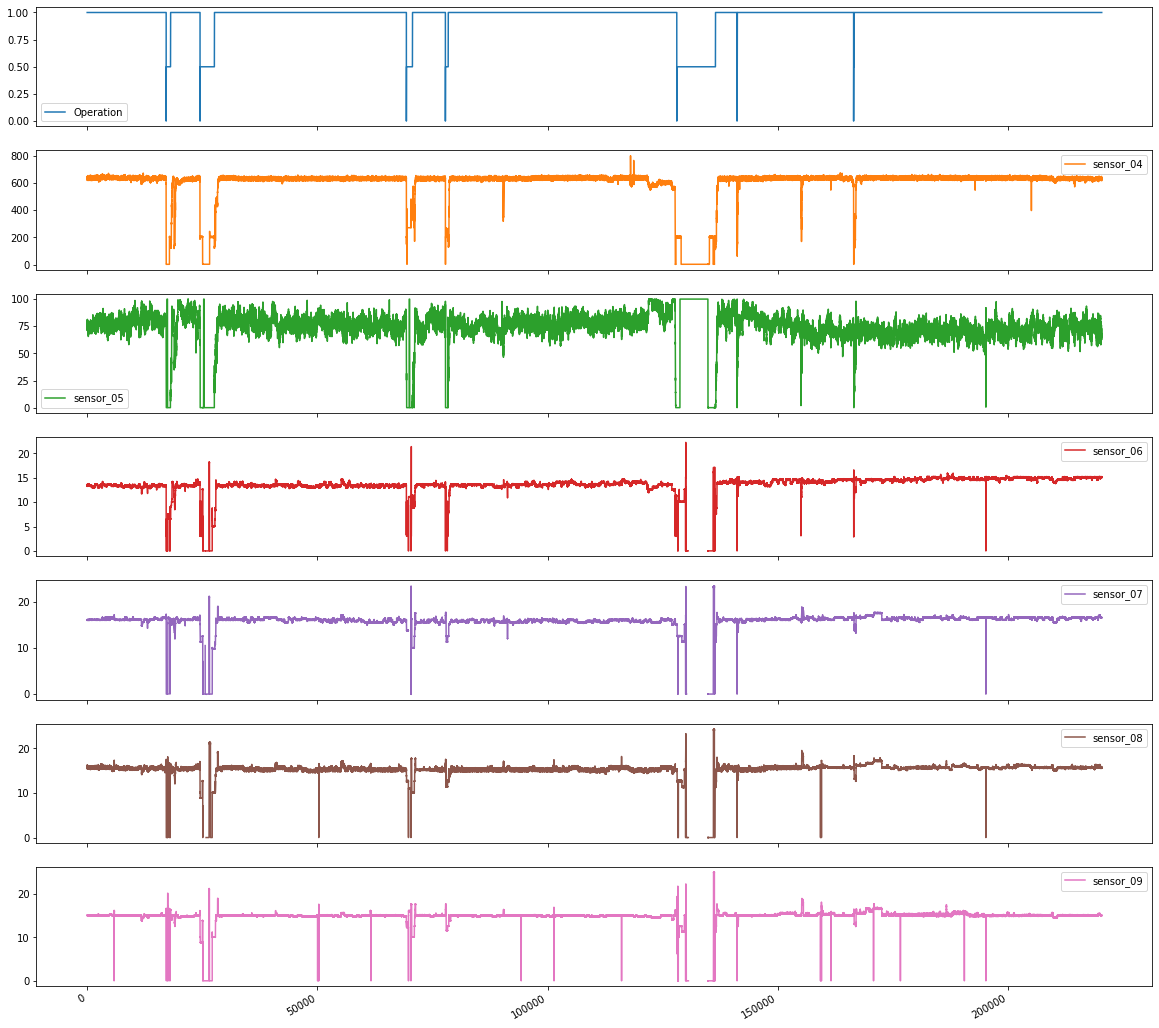

In [ ]:
df0 = pd.DataFrame(data, columns=['Operation','sensor_04','sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09'])
df0.plot(subplots =True, sharex = True, figsize = (20,20))

In [ ]:
df = df0
df.shape

(220320, 7)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# split dataset into train and test 
values = reframed.values
n_train_time = 22000 
# training on ~10% of dataset
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


Epoch 1/10
315/315 - 5s - loss: 0.0450 - val_loss: 0.0022
Epoch 2/10
315/315 - 4s - loss: 0.0055 - val_loss: 0.0019
Epoch 3/10
315/315 - 4s - loss: 0.0051 - val_loss: 0.0021
Epoch 4/10
315/315 - 4s - loss: 0.0048 - val_loss: 0.0026
Epoch 5/10
315/315 - 4s - loss: 0.0045 - val_loss: 0.0024
Epoch 6/10
315/315 - 4s - loss: 0.0044 - val_loss: 0.0025
Epoch 7/10
315/315 - 4s - loss: 0.0042 - val_loss: 0.0017
Epoch 8/10
315/315 - 4s - loss: 0.0040 - val_loss: 0.0020
Epoch 9/10
315/315 - 4s - loss: 0.0038 - val_loss: 0.0013
Epoch 10/10
315/315 - 4s - loss: 0.0036 - val_loss: 0.0013


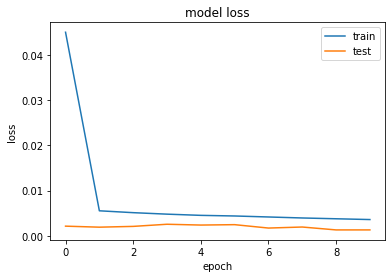

Test RMSE: 0.036


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_x, train_y, epochs=10, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df.shape[1]

# Predict
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

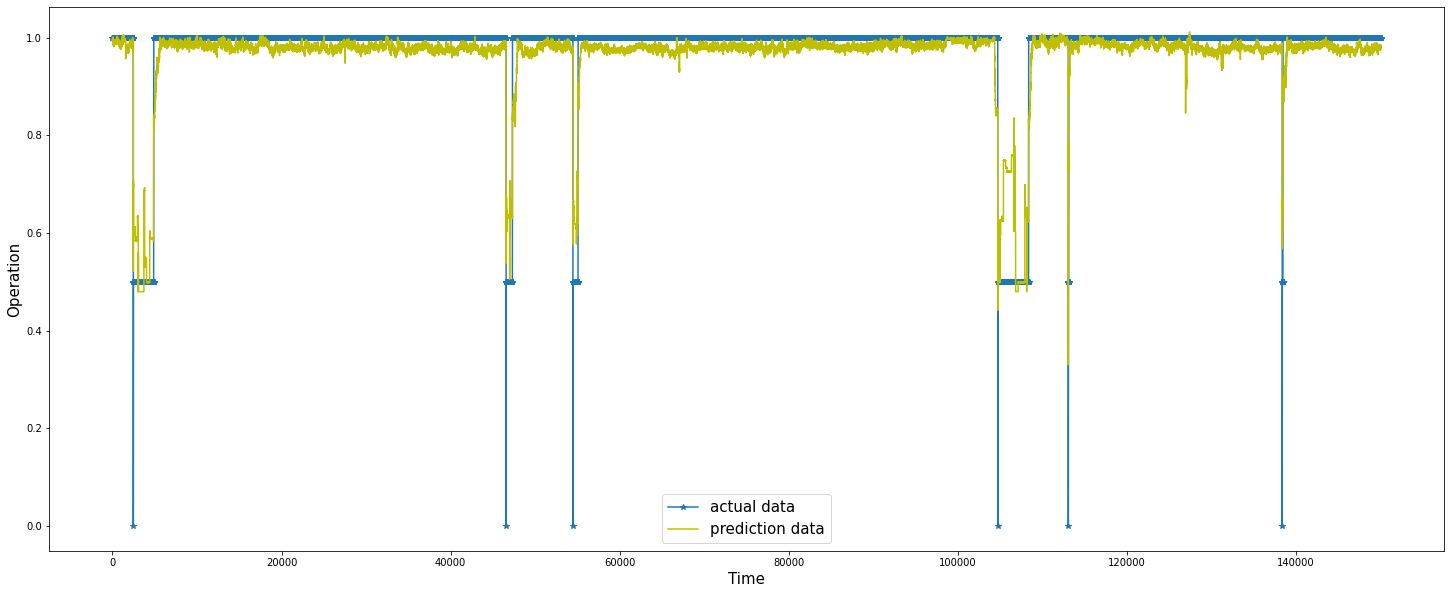

In [ ]:
e = 100 - round(sum(abs(inv_y[:]-inv_yhat[:]))/len(inv_y[:])*100,2)
aa=[x for x in range(150000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:150000], marker='*', label="actual data")
plt.plot(aa, inv_yhat[:150000], 'y', label="prediction data")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show()